# Predicting Road Accident Risk - S5E10
## Kaggle Playground Series

**Objective**: Predict accident risk scores using tabular data with advanced feature engineering and ensemble methods.

**Strategy**:
1. Exploratory Data Analysis (EDA)
2. Feature Engineering & Preprocessing
3. Baseline Models (LightGBM, XGBoost, CatBoost)
4. Stacking Ensemble with RidgeCV Meta-Model
5. Cross-Validation & Hyperparameter Tuning
6. Submission Preparation

## 1. Import Libraries & Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Boosting models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import os
print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Load data
train = pd.read_csv('/kaggle/input/playground-series-s5e10/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"\nFirst few rows of train data:")
print(train.head())
print(f"\nData types:")
print(train.dtypes)
print(f"\nMissing values:")
print(train.isnull().sum())

Train shape: (517754, 14)
Test shape: (172585, 13)

First few rows of train data:
   id road_type  num_lanes  curvature  speed_limit  lighting weather  \
0   0     urban          2       0.06           35  daylight   rainy   
1   1     urban          4       0.99           35  daylight   clear   
2   2     rural          4       0.63           70       dim   clear   
3   3   highway          4       0.07           35       dim   rainy   
4   4     rural          1       0.58           60  daylight   foggy   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0               False         True   afternoon    False           True   
1                True        False     evening     True           True   
2               False         True     morning     True          False   
3                True         True     morning    False          False   
4               False        False     evening     True          False   

   num_reported_accidents  accident_risk

## 2. Exploratory Data Analysis (EDA)

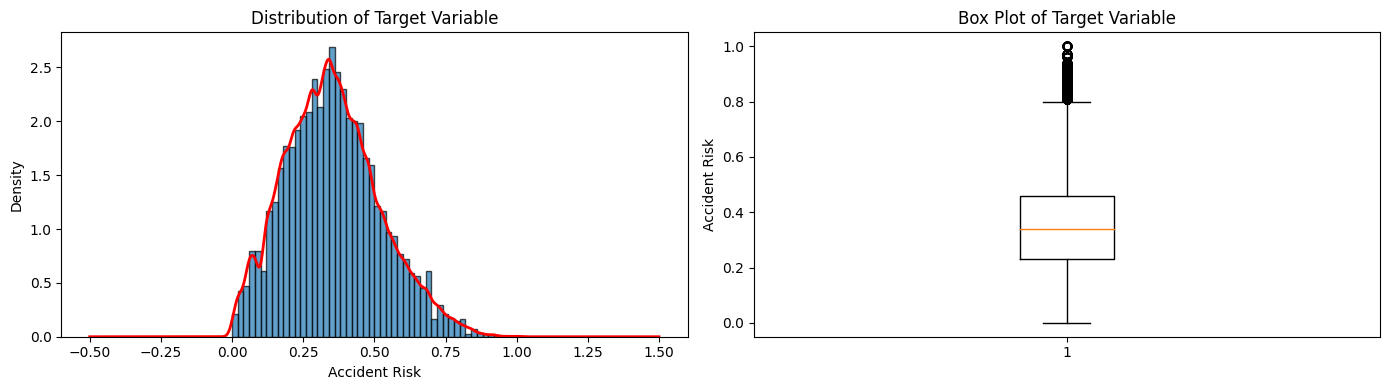

Target statistics:
count    517754.000000
mean          0.352377
std           0.166417
min           0.000000
25%           0.230000
50%           0.340000
75%           0.460000
max           1.000000
Name: accident_risk, dtype: float64


In [4]:
# Target variable analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Histogram with KDE
axes[0].hist(train['accident_risk'], bins=50, edgecolor='black', alpha=0.7, density=True)
axes[0].set_xlabel('Accident Risk')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Target Variable')
train['accident_risk'].plot(kind='density', ax=axes[0], color='red', linewidth=2)

# Box plot
axes[1].boxplot(train['accident_risk'])
axes[1].set_ylabel('Accident Risk')
axes[1].set_title('Box Plot of Target Variable')

plt.tight_layout()
plt.show()

print(f"Target statistics:")
print(train['accident_risk'].describe())

In [5]:
# Identify feature types
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()

# Remove target and ID columns
if 'accident_risk' in numeric_cols:
    numeric_cols.remove('accident_risk')
if 'id' in numeric_cols:
    numeric_cols.remove('id')

print(f"Numeric features ({len(numeric_cols)}): {numeric_cols}")
print(f"\nCategorical features ({len(categorical_cols)}): {categorical_cols}")

Numeric features (4): ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']

Categorical features (4): ['road_type', 'lighting', 'weather', 'time_of_day']


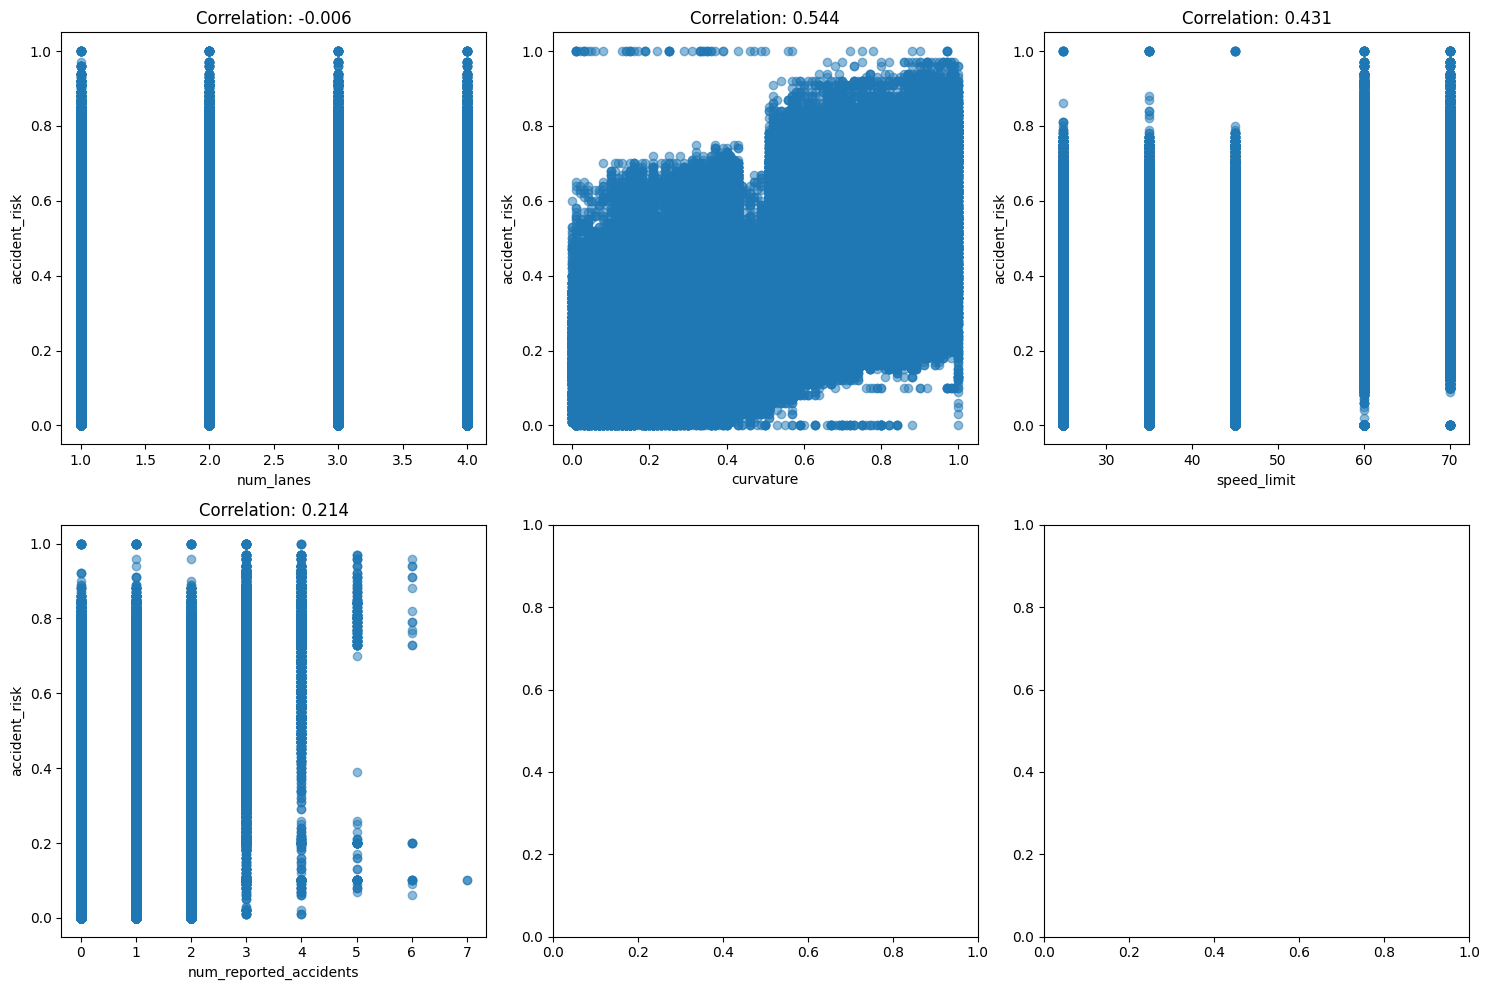

In [6]:
# Numeric features correlation with target
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols[:6]):
    axes[idx].scatter(train[col], train['accident_risk'], alpha=0.5)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('accident_risk')
    corr = train[[col, 'accident_risk']].corr().iloc[0, 1]
    axes[idx].set_title(f'Correlation: {corr:.3f}')

plt.tight_layout()
plt.show()

In [7]:
# Categorical features analysis
for col in categorical_cols:
    print(f"\n{col}:")
    print(train[col].value_counts())


road_type:
road_type
highway    173672
rural      172719
urban      171363
Name: count, dtype: int64

lighting:
lighting
dim         183826
daylight    178015
night       155913
Name: count, dtype: int64

weather:
weather
foggy    181463
clear    179306
rainy    156985
Name: count, dtype: int64

time_of_day:
time_of_day
morning      173410
evening      172837
afternoon    171507
Name: count, dtype: int64


## 3. Data Preprocessing & Feature Engineering

In [8]:
def preprocess_and_engineer_features(data, is_train=True):
    df = data.copy()
    
    # Separate target if training
    if is_train:
        target = df['accident_risk']
        df = df.drop(['accident_risk', 'id'], axis=1)
    else:
        df = df.drop(['id'], axis=1)
        target = None
    
    # 1. Encode categorical variables
    for col in categorical_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
    
    # 2. Feature Engineering
    
    # Interaction features (combine key features)
    if 'speed_limit' in df.columns and 'curvature' in df.columns:
        df['speed_curvature'] = df['speed_limit'] * df['curvature']
    
    if 'num_lanes' in df.columns:
        df['lane_density'] = df['num_lanes'] ** 2
    
    # Polynomial features for important columns
    for col in numeric_cols:
        if col in df.columns:
            df[f'{col}_squared'] = df[col] ** 2
            if df[col].min() > 0:
                df[f'{col}_log'] = np.log1p(df[col])
    
    # 3. Scaling numeric features
    scaler = StandardScaler()
    numeric_to_scale = [col for col in numeric_cols if col in df.columns]
    df[numeric_to_scale] = scaler.fit_transform(df[numeric_to_scale])
    
    # Handle any remaining NaNs
    df = df.fillna(df.mean())
    
    if is_train:
        return df, target
    else:
        return df

X_train, y_train = preprocess_and_engineer_features(train, is_train=True)
X_test = preprocess_and_engineer_features(test, is_train=False)

print(f"Processed X_train shape: {X_train.shape}")
print(f"Processed X_test shape: {X_test.shape}")
print(f"\nFeature names (first 10): {X_train.columns.tolist()[:10]}")

Processed X_train shape: (517754, 20)
Processed X_test shape: (172585, 20)

Feature names (first 10): ['road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday']


## 4. Baseline Model Training

In [9]:
# Initialize cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize base models
lgb_model = LGBMRegressor(
    objective='regression',
    metric='rmse',
    n_estimators=2500,
    learning_rate=0.03,
    max_depth=8,
    num_leaves=100,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    verbosity=-1
)

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    n_estimators=2500,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)

cat_model = CatBoostRegressor(
    iterations=2500,
    learning_rate=0.03,
    depth=8,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_state=42,
    verbose=False
)

# Evaluate baseline models with cross-validation
lgb_scores = -cross_val_score(lgb_model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
lgb_rmse = np.sqrt(lgb_scores)
print(f"LightGBM CV RMSE: {lgb_rmse.mean():.5f} (+/- {lgb_rmse.std():.5f})")

xgb_scores = -cross_val_score(xgb_model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
xgb_rmse = np.sqrt(xgb_scores)
print(f"XGBoost CV RMSE: {xgb_rmse.mean():.5f} (+/- {xgb_rmse.std():.5f})")

cat_scores = -cross_val_score(cat_model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
cat_rmse = np.sqrt(cat_scores)
print(f"CatBoost CV RMSE: {cat_rmse.mean():.5f} (+/- {cat_rmse.std():.5f})")

LightGBM CV RMSE: 0.05628 (+/- 0.00012)
XGBoost CV RMSE: 0.05674 (+/- 0.00013)
CatBoost CV RMSE: 0.05609 (+/- 0.00011)


## 5. Stacking Ensemble with Out-Of-Fold Predictions

In [10]:
def create_oof_predictions(X, y, model, kfold, model_name):
    """
    Create out-of-fold predictions for stacking
    """
    oof_predictions = np.zeros(X.shape[0])
    test_predictions = np.zeros(X_test.shape[0])
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print(f"{model_name} - Fold {fold + 1}/5", end="\r")
        
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        # Clone and train model
        if model_name == 'LightGBM':
            fold_model = LGBMRegressor(
                objective='regression',
                metric='rmse',
                n_estimators=2500,
                learning_rate=0.03,
                max_depth=8,
                num_leaves=100,
                subsample=0.9,
                colsample_bytree=0.9,
                random_state=42,
                verbosity=-1
            )
        elif model_name == 'XGBoost':
            fold_model = XGBRegressor(
                objective='reg:squarederror',
                eval_metric='rmse',
                n_estimators=2500,
                learning_rate=0.03,
                max_depth=8,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                verbosity=0
            )
        else:  # CatBoost
            fold_model = CatBoostRegressor(
                iterations=2500,
                learning_rate=0.03,
                depth=8,
                loss_function='RMSE',
                eval_metric='RMSE',
                random_state=42,
                verbose=False
            )
        
        fold_model.fit(X_train_fold, y_train_fold)
        
        # OOF predictions
        oof_predictions[val_idx] = fold_model.predict(X_val_fold)
        
        # Test predictions
        test_predictions += fold_model.predict(X_test) / 5
    
    return oof_predictions, test_predictions

print("Creating Out-Of-Fold predictions for stacking...")
print()

lgb_oof, lgb_test = create_oof_predictions(X_train, y_train, lgb_model, kfold, 'LightGBM')
print(f"LightGBM OOF RMSE: {np.sqrt(mean_squared_error(y_train, lgb_oof)):.5f}")

xgb_oof, xgb_test = create_oof_predictions(X_train, y_train, xgb_model, kfold, 'XGBoost')
print(f"XGBoost OOF RMSE: {np.sqrt(mean_squared_error(y_train, xgb_oof)):.5f}")

cat_oof, cat_test = create_oof_predictions(X_train, y_train, cat_model, kfold, 'CatBoost')
print(f"CatBoost OOF RMSE: {np.sqrt(mean_squared_error(y_train, cat_oof)):.5f}")

Creating Out-Of-Fold predictions for stacking...

LightGBM OOF RMSE: 0.05628
XGBoost OOF RMSE: 0.05674
CatBoost OOF RMSE: 0.05609


In [11]:
# Create stacking features
train_stack = np.column_stack([
    lgb_oof, xgb_oof, cat_oof
])

test_stack = np.column_stack([
    lgb_test, xgb_test, cat_test
])

# Add meta-features: mean and standard deviation
train_stack_ext = np.column_stack([
    train_stack,
    train_stack.mean(axis=1),
    train_stack.std(axis=1),
    train_stack[:, 0] * train_stack[:, 1],  # LGB * XGB
    train_stack[:, 1] * train_stack[:, 2],  # XGB * CAT
    train_stack[:, 0] * train_stack[:, 2],  # LGB * CAT
])

test_stack_ext = np.column_stack([
    test_stack,
    test_stack.mean(axis=1),
    test_stack.std(axis=1),
    test_stack[:, 0] * test_stack[:, 1],
    test_stack[:, 1] * test_stack[:, 2],
    test_stack[:, 0] * test_stack[:, 2],
])

print(f"Training stack shape: {train_stack_ext.shape}")
print(f"Test stack shape: {test_stack_ext.shape}")

Training stack shape: (517754, 8)
Test stack shape: (172585, 8)


## 6. Meta-Model Training (RidgeCV)

In [12]:
# Train meta-model
alphas = [1e-3, 1e-2, 0.05, 0.1, 0.3, 1.0, 3.0, 10.0]
meta_model = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5)
meta_model.fit(train_stack_ext, y_train)

print(f"Best alpha: {meta_model.alpha_}")

# Evaluate
final_oof = meta_model.predict(train_stack_ext)
final_rmse = np.sqrt(mean_squared_error(y_train, final_oof))
final_mae = mean_absolute_error(y_train, final_oof)

print(f"\nFinal Stacking RMSE (RidgeCV): {final_rmse:.5f}")
print(f"Final Stacking MAE (RidgeCV): {final_mae:.5f}")

Best alpha: 0.3

Final Stacking RMSE (RidgeCV): 0.05607
Final Stacking MAE (RidgeCV): 0.04358


## 7. Final Predictions & Submission

In [13]:
# Generate test predictions
final_test_predictions = meta_model.predict(test_stack_ext)

# Create submission
submission = pd.DataFrame({
    'id': test['id'],
    'accident_risk': final_test_predictions
})

print(f"Submission shape: {submission.shape}")
print(f"\nFirst few rows:")
print(submission.head())
print(f"\nPrediction statistics:")
print(submission['accident_risk'].describe())

Submission shape: (172585, 2)

First few rows:
       id  accident_risk
0  517754       0.294260
1  517755       0.118158
2  517756       0.183399
3  517757       0.309782
4  517758       0.398725

Prediction statistics:
count    172585.000000
mean          0.352031
std           0.157570
min          -0.028350
25%           0.241887
50%           0.336963
75%           0.454157
max           0.889549
Name: accident_risk, dtype: float64


In [14]:
# Save submission
submission.to_csv('submission.csv', index=False)
print("✓ Submission saved as 'submission.csv'")

# Display file location
print(f"File location: {os.path.abspath('submission.csv')}")

✓ Submission saved as 'submission.csv'
File location: /kaggle/working/submission.csv


## 8. Model Analysis & Feature Importance

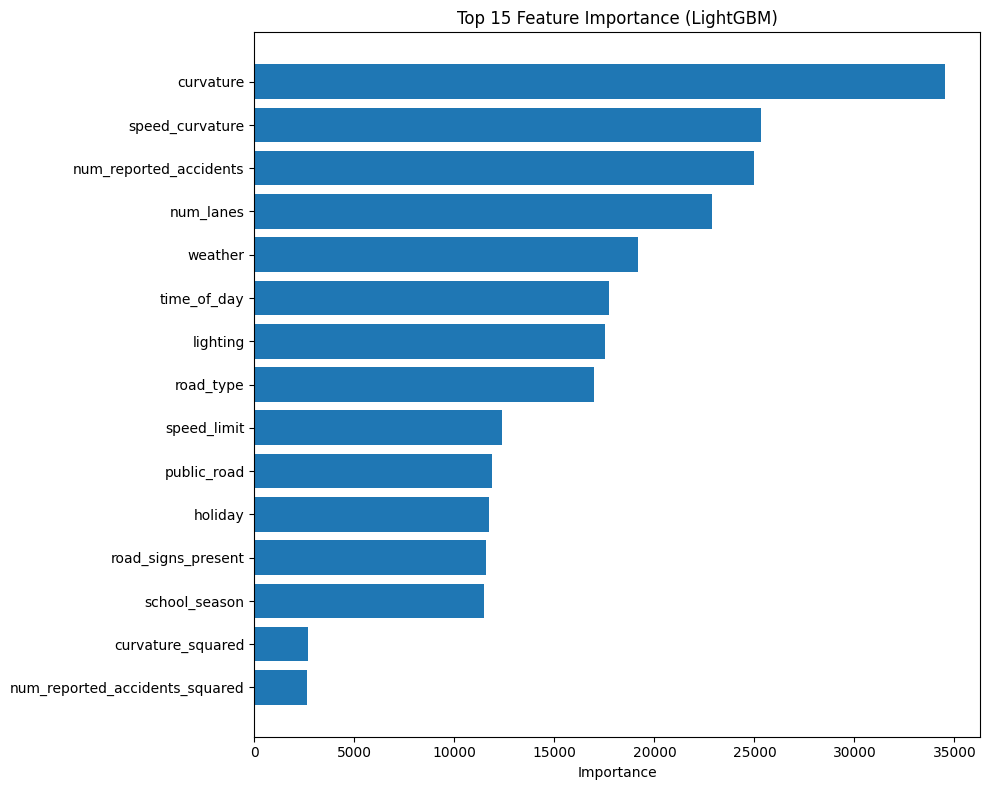

Top 10 Important Features:
                   feature  importance
2                curvature       34550
12         speed_curvature       25346
11  num_reported_accidents       24961
1                num_lanes       22865
5                  weather       19163
8              time_of_day       17716
4                 lighting       17542
0                road_type       16996
3              speed_limit       12375
7              public_road       11881


In [15]:
# Feature importance from base models
# Train final models on full training data
lgb_final = LGBMRegressor(
    objective='regression',
    metric='rmse',
    n_estimators=2500,
    learning_rate=0.03,
    max_depth=8,
    num_leaves=100,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    verbosity=-1
)
lgb_final.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_final.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance (LightGBM)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 10 Important Features:")
print(feature_importance.head(10))

## 9. Summary & Results

In [ ]:
print("="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"\nBase Models CV Performance:")
print(f"  - LightGBM RMSE:  {lgb_rmse.mean():.5f} (±{lgb_rmse.std():.5f})")
print(f"  - XGBoost RMSE:   {xgb_rmse.mean():.5f} (±{xgb_rmse.std():.5f})")
print(f"  - CatBoost RMSE:  {cat_rmse.mean():.5f} (±{cat_rmse.std():.5f})")
print(f"\nStacking Ensemble Performance:")
print(f"  - Final RMSE:     {final_rmse:.5f}")
print(f"  - Final MAE:      {final_mae:.5f}")
print(f"  - Meta-Model Alpha: {meta_model.alpha_}")
print(f"\nSubmission Details:")
print(f"  - Test Samples:   {len(submission)}")
print(f"  - Pred Min:       {submission['accident_risk'].min():.5f}")
print(f"  - Pred Max:       {submission['accident_risk'].max():.5f}")
print(f"  - Pred Mean:      {submission['accident_risk'].mean():.5f}")
print(f"  - Pred Std:       {submission['accident_risk'].std():.5f}")
print("="*60)